<a href="https://colab.research.google.com/github/tirth5828/Emotion-Detection/blob/main/facial_age_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading Data

Import and drive mount

In [ ]:
import numpy as np
import os
from os.path import join
import matplotlib.pyplot as plt
#import tensorflow as tf
#from tensorflow.keras import layers, models
from google.colab import drive

# SVM

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# Random Forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# Linear Regression 

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# KNN

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

drive.mount('/content/drive/')



Mounted at /content/drive/


# Variable and label definition

In [ ]:
dataset_directory = '/content/drive/My Drive/data'

image_size = 100

#age groups
age_ranges = {
    (6,20) : 0, 
    (35,40) : 1, 
    (55,98) : 2
}

# convert age to age group
def convert_ranges(age):
  for key in age_ranges:
    if key[0] <= age <= key[1]:
      return age_ranges[key]

# transform labels to age
def transform_labels_age(labels_vec):
  new_labels_vec = []
  for x in labels_vec:
    x2 = x.split('-')
    new_labels_vec.append(convert_ranges(int(x2[1])))
  return np.array(new_labels_vec)

# transform labels to index
def transform_labels_index(labels_vec):
  new_labels_vec = []
  for x in labels_vec:
    x2 = x.split('-')
    new_labels_vec.append(convert_ranges(int(x2[0])))
  return np.array(new_labels_vec)

# Initial Data loading and rescaling

In [ ]:
# load train dataset
# set of data to be used for learning
images_train = np.load(join(dataset_directory, 'train_images.npy'))

# load train dataset labels
labels_train_full = np.load(join(dataset_directory, 'train_labels.npy'))

# transform trains dataset labels....................................................................................
labels_train = transform_labels_age(labels_train_full)

# load valid dataset
# set of data to be used to provide an unbiased evaluation of the model fitted on the the training dataset while tuning model hyperparameters
images_val = np.load(join(dataset_directory, 'val_images.npy'))

# load valid dataset labels
labels_val_full = np.load(join(dataset_directory, 'val_labels.npy'))

# transmiform valid dataset labels....................................................................................
labels_val = transform_labels_age(labels_val_full)

# load test dataset(public)
# set of data to be used to provide an unbiased evaluation of the final model fitted on the training dataset
images_test_public = np.load(join(dataset_directory, 'test_images.npy'))

# reshape datasets (normalisation)
images_train = images_train.reshape([-1, image_size, image_size, 3]) / 255.0
images_val = images_val.reshape([-1, image_size, image_size, 3]) / 255.0
images_test_public = images_test_public.reshape([-1, image_size, image_size, 3]) / 255.0

print(images_train.shape)
print(images_val.shape)
print(images_test_public.shape)

print(labels_train_full[:9])
print(labels_train[:9])

print(labels_val_full[:9])
print(labels_val[:9])


(13475, 100, 100, 3)
(2595, 100, 100, 3)
(2374, 100, 100, 3)
['12466-81' '12466-61' '12466-81' '12466-61' '12566-35' '12566-37'
 '12566-35' '12566-35' '12566-37']
[2 2 2 2 1 1 1 1 1]
['12626-16' '12726-37' '12726-37' '12726-37' '12726-37' '12726-37'
 '12726-37' '12726-39' '12726-37']
[0 1 1 1 1 1 1 1 1]


#Verify Distribution of Data

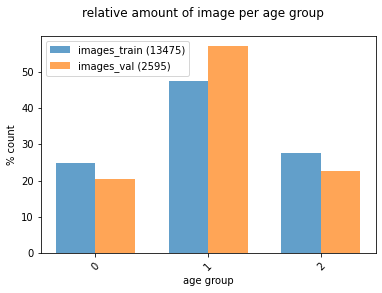

In [ ]:
def plot_bar(y, loc='left', relative=True):
    width = 0.35
    if loc == 'left':
        n = -0.5
    elif loc == 'right':
        n = 0.5
     
    # calculate counts per type and sort, to ensure their order
    unique, counts = np.unique(y, return_counts=True)
    sorted_index = np.argsort(unique)
    unique = unique[sorted_index]
     
    if relative:
        # plot as a percentage
        counts = 100*counts[sorted_index]/len(y)
        ylabel_text = '% count'
    else:
        # plot counts
        counts = counts[sorted_index]
        ylabel_text = 'count'
         
    xtemp = np.arange(len(unique))
     
    plt.bar(xtemp + n*width, counts, align='center', alpha=.7, width=width)
    plt.xticks(xtemp, unique, rotation=45)
    plt.xlabel('age group')
    plt.ylabel(ylabel_text)
 
plt.suptitle('relative amount of image per age group')
plot_bar(labels_train, loc='left')
plot_bar(labels_val, loc='right')
plt.legend([
    'images_train ({0})'.format(len(labels_train)), 
    'images_val ({0})'.format(len(labels_val))
]);

#Handling Multiple Instances of Image of the Same Person in the Training Dataset

#Verify Distribution of Data After Handling Multiple Instances

# Visualising training images

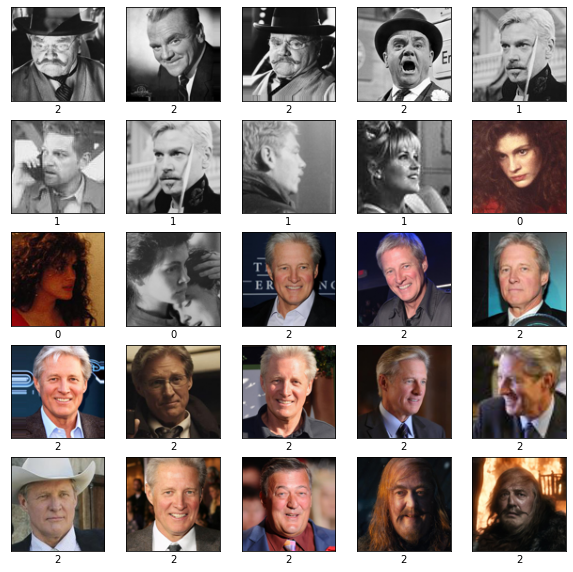

In [ ]:
plt.figure(figsize=(10,10))
offset = 0
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images_train[i+offset], cmap=plt.cm.binary)
    plt.xlabel(labels_train[i+offset])
plt.show()

# Visualising validation images

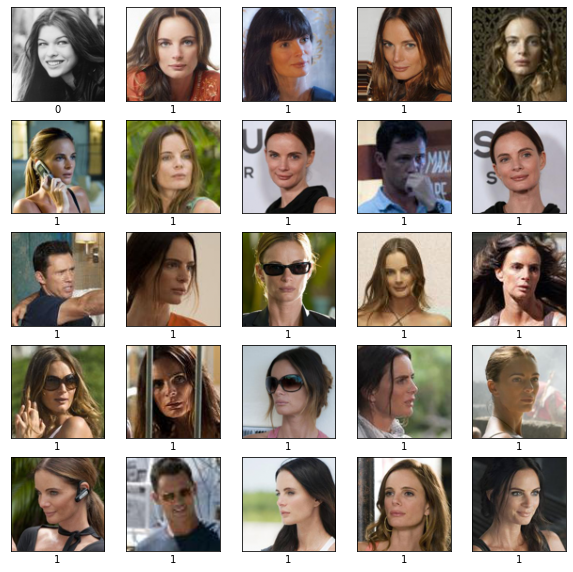

In [ ]:
plt.figure(figsize=(10,10))
offset = 0
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images_val[i+offset], cmap=plt.cm.binary)
    plt.xlabel(labels_val[i+offset])
plt.show()

In [ ]:
print(images_train[1])

[[[0.68627451 0.68627451 0.68627451]
  [0.68627451 0.68627451 0.68627451]
  [0.68235294 0.68235294 0.68235294]
  ...
  [0.0627451  0.0627451  0.0627451 ]
  [0.0627451  0.0627451  0.0627451 ]
  [0.0627451  0.0627451  0.0627451 ]]

 [[0.70196078 0.70196078 0.70196078]
  [0.70196078 0.70196078 0.70196078]
  [0.70196078 0.70196078 0.70196078]
  ...
  [0.07843137 0.07843137 0.07843137]
  [0.07843137 0.07843137 0.07843137]
  [0.07843137 0.07843137 0.07843137]]

 [[0.72156863 0.72156863 0.72156863]
  [0.72156863 0.72156863 0.72156863]
  [0.72156863 0.72156863 0.72156863]
  ...
  [0.08627451 0.08627451 0.08627451]
  [0.08627451 0.08627451 0.08627451]
  [0.08627451 0.08627451 0.08627451]]

 ...

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]


#Reshaping Datasets

In [ ]:
# sklearn expects a 2D array as input to the fit() function, so we need to reshape the datasets to a two-dimensional array 
nsamples, nx, ny, nrgb = images_train.shape
images_train_2d = images_train.reshape((nsamples,nx*ny*nrgb))

nsamples, nx, ny, nrgb = images_val.shape
images_val_2d = images_val.reshape((nsamples,nx*ny*nrgb))

nsamples, nx, ny, nrgb = images_test_public.shape
images_test_public_2d = images_test_public.reshape((nsamples,nx*ny*nrgb))

#Apply StandardScaler

standardize features by removing the mean and scaling to unit variance

In [ ]:
from sklearn.preprocessing import StandardScaler

# create StandardScaler object
scaler = StandardScaler()

# fit to datasets, then transform it
images_train_2d = scaler.fit_transform(images_train_2d)
images_val_2d = scaler.fit_transform(images_val_2d)
images_test_public_2d = scaler.fit_transform(images_test_public_2d)


In [ ]:
print(images_train_2d.shape)
print(images_val_2d.shape)
print(images_test_public_2d.shape)

(13475, 30000)
(2595, 30000)
(2374, 30000)


In [ ]:
print(images_train_2d)


[[ 0.13787998  0.22342245  0.30591465 ... -0.46293751 -0.34587616
  -0.28200223]
 [ 0.81583624  0.90490674  0.97492877 ... -1.29741405 -1.24860077
  -1.20435589]
 [-0.71915907 -0.63807655 -0.53982018 ...  1.49742006  1.77481024
   1.88479687]
 ...
 [ 0.02275533 -0.61236016 -0.56506599 ... -0.91328993 -0.99067945
  -0.79442093]
 [ 0.31696277  0.28771343  0.15443976 ... -0.99276388 -0.9333636
  -0.94082627]
 [ 1.50658413 -0.49663642 -0.83014706 ... -0.71460504 -0.6324554
  -0.48696971]]


#**Compute a PCA**

*Not helping

In [ ]:
from sklearn.decomposition import PCA

#n_components = 500

# Compute a PCA(eigenfaces) on the face dataset (treated as unlabeled dataset): unsupervised feature extraction / dimensionality reduction
#pca = PCA(n_components=n_components, svd_solver="randomized", whiten=True).fit(images_train_2d)

#images_train_2d_pca = pca.transform(images_train_2d)
#images_val_2d_pca = pca.transform(images_val_2d)

#**Feature Extraction**

Using Histogram of Oriented Gradients (HOG) for feature representation

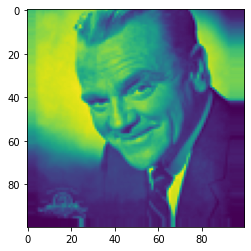

In [ ]:
from skimage import color
from skimage.feature import hog

images_train_gray = [ color.rgb2gray(i) for i in images_train]
images_val_gray = [ color.rgb2gray(i) for i in images_val]
images_test_gray = [ color.rgb2gray(i) for i in images_test_public]
plt.imshow(images_train_gray[1])

In [ ]:
print(len(images_train_gray))
print(len(images_val_gray))
print(len(images_test_gray))

print(images_train_gray[0])

13475
2595
2374
[[0.47843137 0.36862745 0.29019608 ... 0.16078431 0.17254902 0.18823529]
 [0.43921569 0.33333333 0.29019608 ... 0.18431373 0.20784314 0.21568627]
 [0.38039216 0.29411765 0.35294118 ... 0.25490196 0.3254902  0.30196078]
 ...
 [0.63921569 0.32941176 0.22352941 ... 0.19215686 0.22745098 0.28235294]
 [0.62745098 0.36862745 0.24313725 ... 0.18823529 0.20784314 0.27843137]
 [0.57647059 0.40784314 0.25882353 ... 0.19607843 0.20392157 0.24705882]]


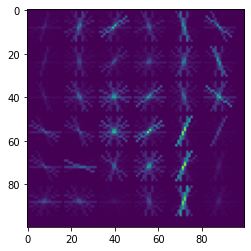

In [ ]:
ppc = 16
cpb = 4
train_hog_images = []
train_hog_features = []
for image in images_train_gray:
    fd,hog_image = hog(image, orientations=9, pixels_per_cell=(ppc,ppc),cells_per_block=(cpb, cpb),block_norm= 'L2',visualize=True)
    train_hog_images.append(hog_image)
    train_hog_features.append(fd)

val_hog_images = []
val_hog_features = []
for image in images_val_gray:
    fd,hog_image = hog(image, orientations=9, pixels_per_cell=(ppc,ppc),cells_per_block=(cpb, cpb),block_norm= 'L2',visualize=True)
    val_hog_images.append(hog_image)
    val_hog_features.append(fd)

test_hog_images = []
test_hog_features = []
for image in images_test_public:
    # fd,hog_image = hog(image, orientations=9, pixels_per_cell=(ppc,ppc),cells_per_block=(cpb, cpb),block_norm= 'L2',visualize=True)
    fd,hog_image = hog(image, orientations=9, pixels_per_cell=(ppc,ppc),cells_per_block=(cpb, cpb),block_norm= 'L2',visualize=True)
    test_hog_images.append(hog_image)
    test_hog_features.append(fd)

plt.imshow(train_hog_images[1])

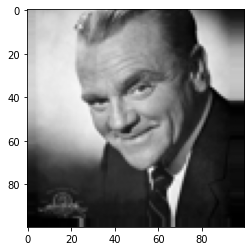

In [ ]:
plt.imshow(images_train[1])

In [ ]:
train_hog_features = np.array(train_hog_features)
val_hog_features = np.array(val_hog_features)
print(train_hog_features.shape)
print(val_hog_features.shape)

(13475, 1296)
(2595, 1296)


# **Using Support Vector Machine (SVM) Classifier**

In [ ]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
accuracy_HOG = {}
accuracy_without_HOG = {}

[LibSVM]Accuracy for SVC (linear):  43.69942196531792
              precision    recall  f1-score   support

           0       0.32      0.61      0.42       529
           1       0.67      0.34      0.45      1479
           2       0.38      0.53      0.44       587

    accuracy                           0.44      2595
   macro avg       0.45      0.49      0.44      2595
weighted avg       0.53      0.44      0.44      2595

[LibSVM]Accuracy for SVC (poly):  60.5009633911368
              precision    recall  f1-score   support

           0       0.51      0.32      0.39       529
           1       0.64      0.80      0.71      1479
           2       0.53      0.38      0.45       587

    accuracy                           0.61      2595
   macro avg       0.56      0.50      0.51      2595
weighted avg       0.59      0.61      0.58      2595

[LibSVM]Accuracy for SVC (rbf):  51.13680154142581
              precision    recall  f1-score   support

           0       0.37    

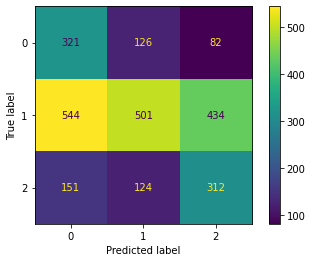

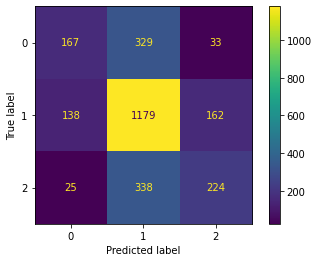

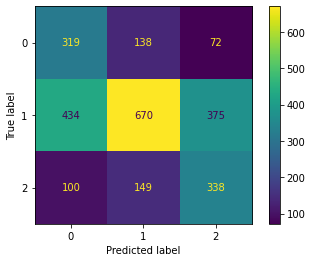

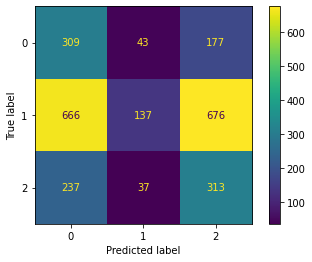

In [ ]:
# RBF SVM with HOG
for kernel in kernels:

  # create SVC object
  SVM_Model = SVC(kernel=kernel,class_weight="balanced",verbose=True,probability = True, random_state=2,degree = 10,gamma = "scale")

  # fit the SVM model according to the given training data
  SVM_Model.fit(train_hog_features, labels_train)

  # make predictions
  SVM_Model_prediction = SVM_Model.predict(val_hog_features)

  # display accuracy score of the model
  print(f"Accuracy for SVC ({kernel}): ", accuracy_score(labels_val, SVM_Model_prediction)*100)

  accuracy_HOG[kernel] = accuracy_score(labels_val, SVM_Model_prediction)*100

  # print classification report
  print(classification_report(labels_val, SVM_Model_prediction))

  # confusion matrix visualisation
  ConfusionMatrixDisplay.from_estimator(SVM_Model, val_hog_features, labels_val)

In [ ]:
# SVM without HOG
for kernel in kernels:

  # create SVC object
  SVM_Model = SVC(kernel=kernel,class_weight=None,verbose=True,probability = False, random_state=0)

  # fit the SVM model according to the given training data
  SVM_Model.fit(images_train_2d, labels_train)

  # make predictions
  SVM_Model_prediction = SVM_Model.predict(images_val_2d)

  # display accuracy score of the model
  print(f"Accuracy for SVC({kernel}): ", accuracy_score(labels_val, SVM_Model_prediction)*100)

  accuracy_without_HOG[kernel] = accuracy_score(labels_val, SVM_Model_prediction)*100

  # print classification report
  print(classification_report(labels_val, SVM_Model_prediction))

  # confusion matrix visualisation
  ConfusionMatrixDisplay.from_estimator(SVM_Model, images_val_2d, labels_val)

[LibSVM]

Accuracy for RandomForestClassifier:  59.34489402697495
              precision    recall  f1-score   support

           0       0.57      0.14      0.22       529
           1       0.60      0.91      0.72      1479
           2       0.53      0.21      0.30       587

    accuracy                           0.59      2595
   macro avg       0.57      0.42      0.42      2595
weighted avg       0.58      0.59      0.53      2595



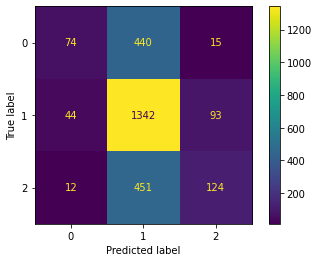

In [ ]:
# create RandomForestClassifier object
RFC_Model = RandomForestClassifier(random_state=42)

# build a forest of trees from the training set (X, y)
RFC_Model.fit(train_hog_features, labels_train)

# make predictions of the validation dataset
RFC_Model_prediction = RFC_Model.predict(val_hog_features)

# display accuracy score of the model
print("Accuracy for RandomForestClassifier: ", accuracy_score(labels_val, RFC_Model_prediction)*100)

RFC_HOG = accuracy_score(labels_val, RFC_Model_prediction)*100

# print classification report
print(classification_report(labels_val, RFC_Model_prediction))

# confusion matrix visualisation
ConfusionMatrixDisplay.from_estimator(RFC_Model, val_hog_features, labels_val)

Accuracy for RandomForestClassifier:  58.22736030828516
              precision    recall  f1-score   support

           0       0.42      0.17      0.24       529
           1       0.62      0.82      0.71      1479
           2       0.50      0.34      0.41       587

    accuracy                           0.58      2595
   macro avg       0.51      0.45      0.45      2595
weighted avg       0.55      0.58      0.54      2595



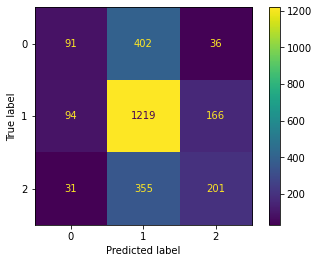

In [ ]:
# create RandomForestClassifier object
RFC_Model = RandomForestClassifier(random_state=42)

# build a forest of trees from the training set (X, y)
RFC_Model.fit(images_train_2d, labels_train)

# make predictions of the validation dataset
RFC_Model_prediction = RFC_Model.predict(images_val_2d)

# display accuracy score of the model
print("Accuracy for RandomForestClassifier: ", accuracy_score(labels_val, RFC_Model_prediction)*100)

RFC_without_HOG = accuracy_score(labels_val, RFC_Model_prediction)*100

# print classification report
print(classification_report(labels_val, RFC_Model_prediction))

# confusion matrix visualisation
ConfusionMatrixDisplay.from_estimator(RFC_Model, images_val_2d, labels_val)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Accuracy for Linear Regression without HOG:  50.63583815028901
              precision    recall  f1-score   support

           0       0.35      0.38      0.37       529
           1       0.64      0.57      0.60      1479
           2       0.38      0.46      0.42       587

    accuracy                           0.51      2595
   macro avg       0.46      0.47      0.46      2595
weighted avg       0.52      0.51      0.51      2595



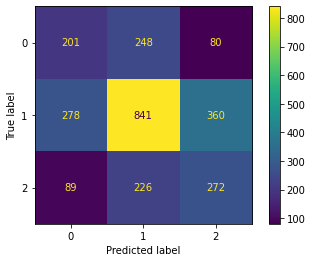

In [ ]:
# create LogisticRegression object
LR_Model = LogisticRegression(max_iter = 200,solver = 'saga')

# fit the LR model according to the given training data
LR_Model.fit(images_train_2d, labels_train)

# make predictions of the validation dataset
LR_Model_prediction = LR_Model.predict(images_val_2d)

# display accuracy score of the model
print("Accuracy for Linear Regression without HOG: ", accuracy_score(labels_val, LR_Model_prediction)*100)

LR_without_HOG = accuracy_score(labels_val, LR_Model_prediction)*100

# print classification report
print(classification_report(labels_val, LR_Model_prediction))

# confusion matrix visualisation
ConfusionMatrixDisplay.from_estimator(LR_Model, images_val_2d, labels_val)

Accuracy for Linear Regression with Hog:  55.10597302504817
              precision    recall  f1-score   support

           0       0.43      0.32      0.36       529
           1       0.62      0.71      0.66      1479
           2       0.42      0.37      0.39       587

    accuracy                           0.55      2595
   macro avg       0.49      0.46      0.47      2595
weighted avg       0.54      0.55      0.54      2595



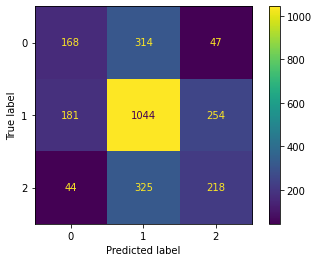

In [ ]:
# create LogisticRegression object
LR_Model = LogisticRegression(max_iter = 1000,solver="newton-cg")

# fit the LR model according to the given training data
LR_Model.fit(train_hog_features, labels_train)

# make predictions of the validation dataset
LR_Model_prediction = LR_Model.predict(val_hog_features)

# display accuracy score of the model
print("Accuracy for Linear Regression with Hog: ", accuracy_score(labels_val, LR_Model_prediction)*100)

LR_HOG = accuracy_score(labels_val, LR_Model_prediction)*100

# print classification report
print(classification_report(labels_val, LR_Model_prediction))

# confusion matrix visualisation
ConfusionMatrixDisplay.from_estimator(LR_Model, val_hog_features, labels_val)

Accuracy for KNN without Hog:  50.55876685934489
              precision    recall  f1-score   support

           0       0.33      0.22      0.26       529
           1       0.61      0.65      0.63      1479
           2       0.35      0.41      0.38       587

    accuracy                           0.51      2595
   macro avg       0.43      0.42      0.42      2595
weighted avg       0.50      0.51      0.50      2595



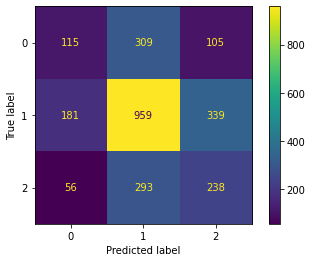

In [ ]:
# create KNN object
KNN_Model = KNeighborsClassifier(weights = 'distance',leaf_size = 50)

# fit the LR model according to the given training data
KNN_Model.fit(images_train_2d, labels_train)

# make predictions of the validation dataset
KNN_Model_prediction = KNN_Model.predict(images_val_2d)

# display accuracy score of the model
print("Accuracy for KNN without Hog: ", accuracy_score(labels_val, KNN_Model_prediction)*100)

KNN_HOG = accuracy_score(labels_val, KNN_Model_prediction)*100

# print classification report
print(classification_report(labels_val, KNN_Model_prediction))

# confusion matrix visualisation
ConfusionMatrixDisplay.from_estimator(KNN_Model, images_val_2d, labels_val)

Accuracy for KNN with Hog:  50.28901734104046
              precision    recall  f1-score   support

           0       0.35      0.29      0.32       529
           1       0.62      0.62      0.62      1479
           2       0.35      0.40      0.38       587

    accuracy                           0.50      2595
   macro avg       0.44      0.44      0.44      2595
weighted avg       0.50      0.50      0.50      2595



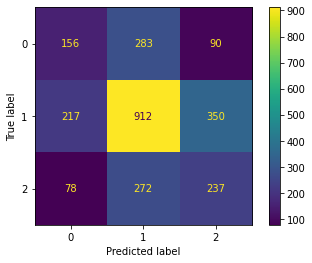

In [ ]:
# create KNN object
KNN_Model = KNeighborsClassifier(weights = 'distance',leaf_size = 50)

# fit the LR model according to the given training data
KNN_Model.fit(train_hog_features, labels_train)

# make predictions of the validation dataset
KNN_Model_prediction = KNN_Model.predict(val_hog_features)

# display accuracy score of the model
print("Accuracy for KNN with Hog: ", accuracy_score(labels_val, KNN_Model_prediction)*100)

KNN_HOG = accuracy_score(labels_val, KNN_Model_prediction)*100

# print classification report
print(classification_report(labels_val, KNN_Model_prediction))

# confusion matrix visualisation
ConfusionMatrixDisplay.from_estimator(KNN_Model, val_hog_features, labels_val)

In [ ]:

# create SVC object
SVM_Model = SVC( kernel="poly",class_weight="balanced",verbose=True,probability = True, random_state=2,degree = 10,gamma = "scale" )

# fit the SVM model according to the given training data
SVM_Model.fit(train_hog_features, labels_train)

# make predictions
SVM_Model_prediction = SVM_Model.predict(val_hog_features)

# display accuracy score of the model
print(f"Accuracy for SVC (poly): ", accuracy_score(labels_val, SVM_Model_prediction)*100)

accuracy_HOG = accuracy_score(labels_val, SVM_Model_prediction)*100

# print classification report
print(classification_report(labels_val, SVM_Model_prediction))

# confusion matrix visualisation
ConfusionMatrixDisplay.from_estimator(SVM_Model, val_hog_features, labels_val)

In [ ]:
# make predictions of the public test dataset
SVM_Model_prediction = SVM_Model.predict(test_hog_features)

**Kaggle Submission**

Produce a CSV with two columns


1.   ID
2.   Prediction

In [ ]:
import pandas as pd 
import os
from datetime import datetime

predictions = SVM_Model_prediction

df = pd.DataFrame(predictions)
df.index.name='ID'
os.chdir('/content/drive/My Drive/results')

currentDateTime = datetime.now().strftime("%d%m%Y_%H%M%S")

#df.to_csv(f'45892342-conv-{currentDateTime}.csv', header=['Prediction'])
df.to_csv(f'45892342-conv-SVM.csv', header=['Prediction'])

In [ ]:
import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage import data, exposure


In [ ]:
image = data.astronaut()

In [ ]:
image = image/255.0
print(image)


In [ ]:
fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),cells_per_block=(1, 1), visualize=True)

In [ ]:
print(hog_image)

In [ ]:
plt.imshow(hog_image)